# **POLICY GRADIENT**

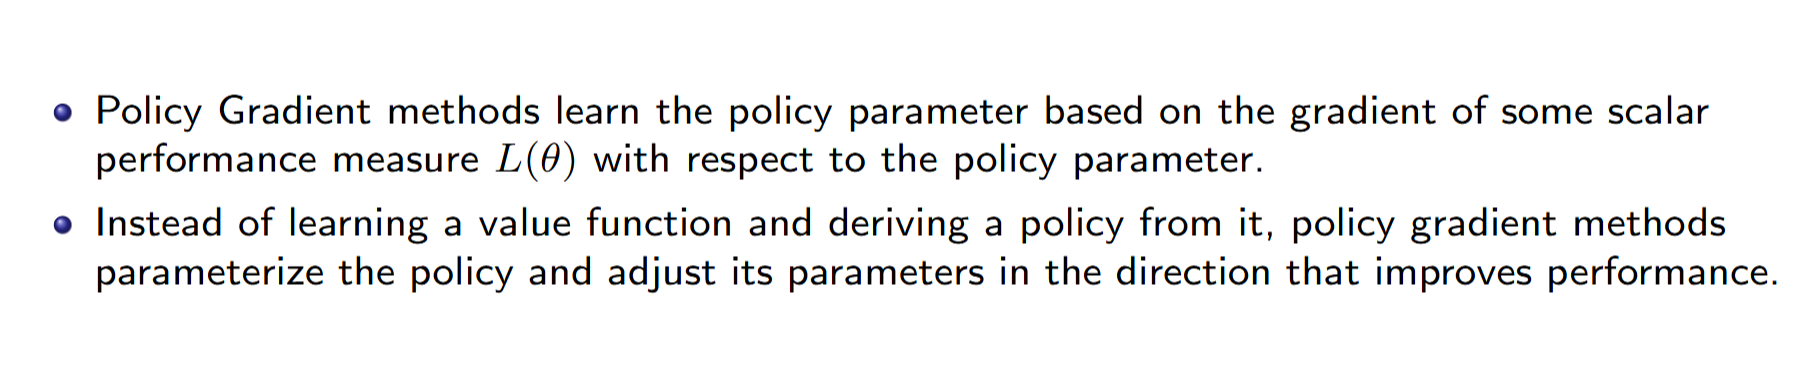

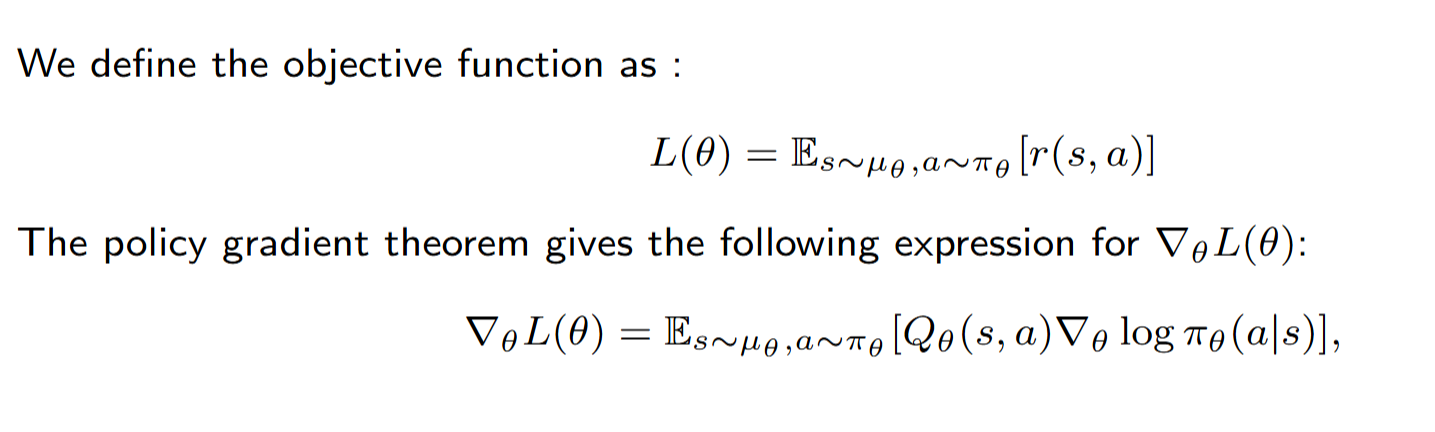

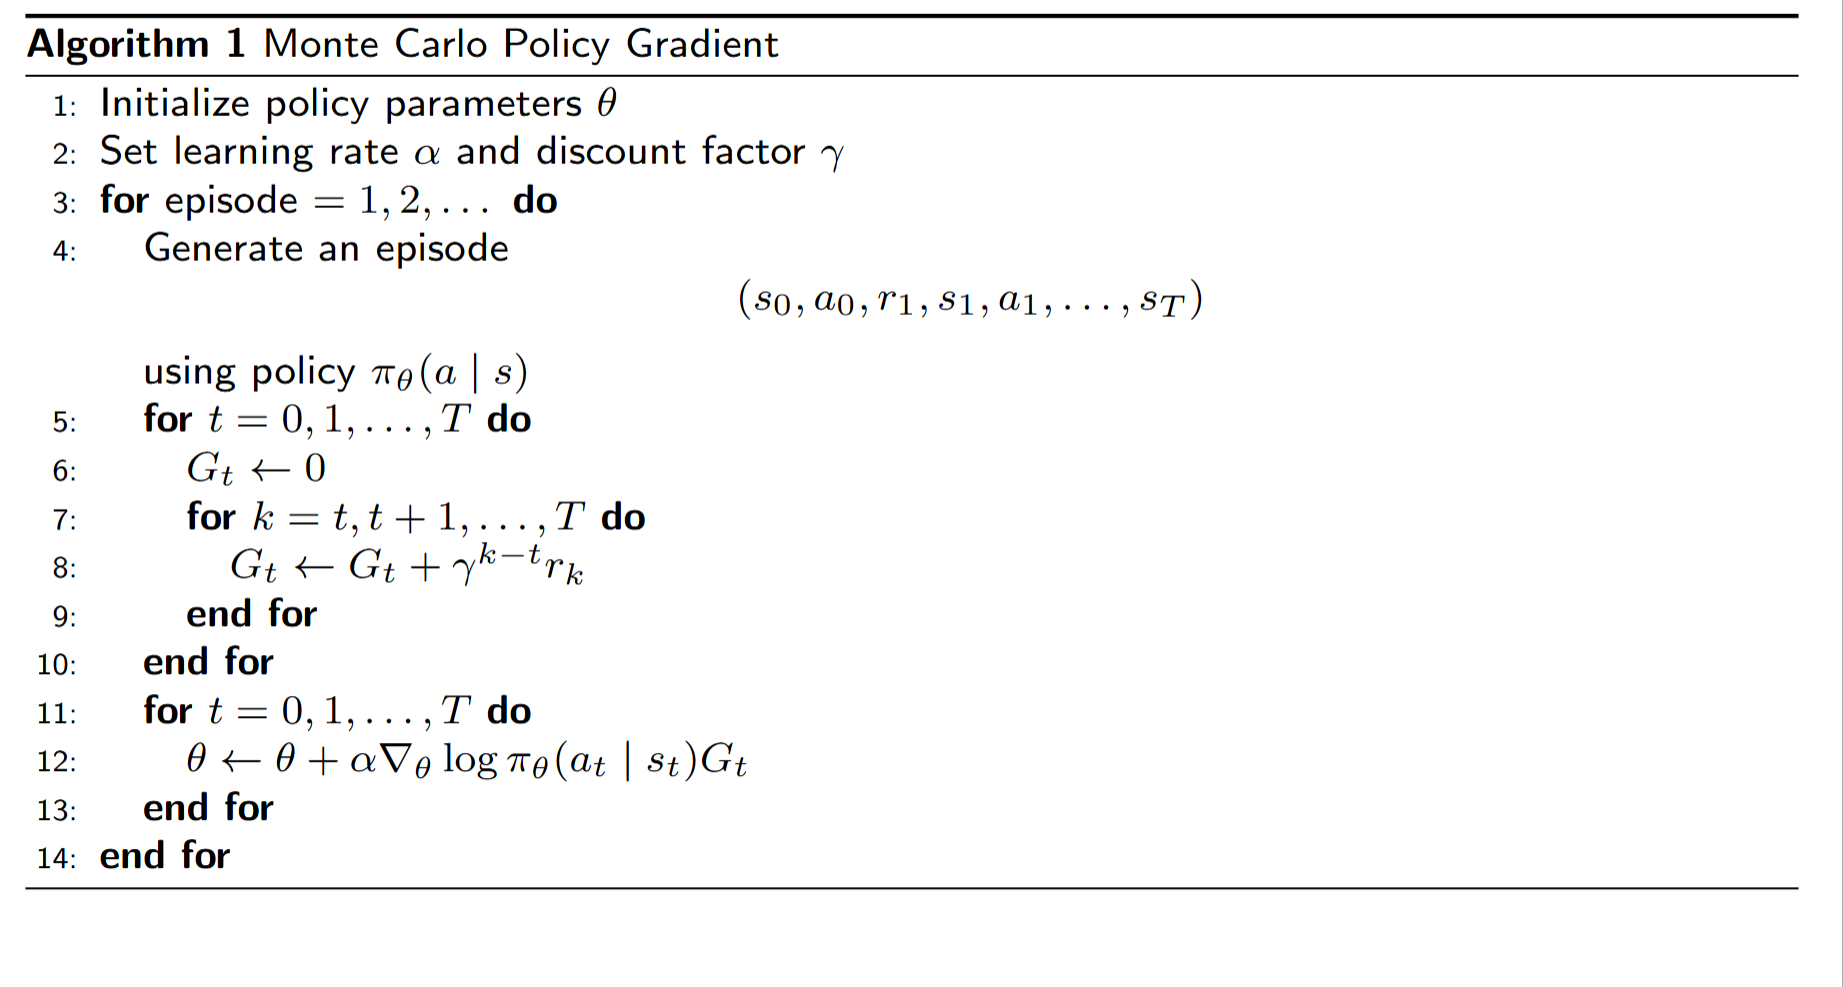

**DISADVANTAGES**





1.  High Variance Gradient Estimates.
2.  Updates Only After Full Episodes.



# **ACTOR CRITIC METHODS**

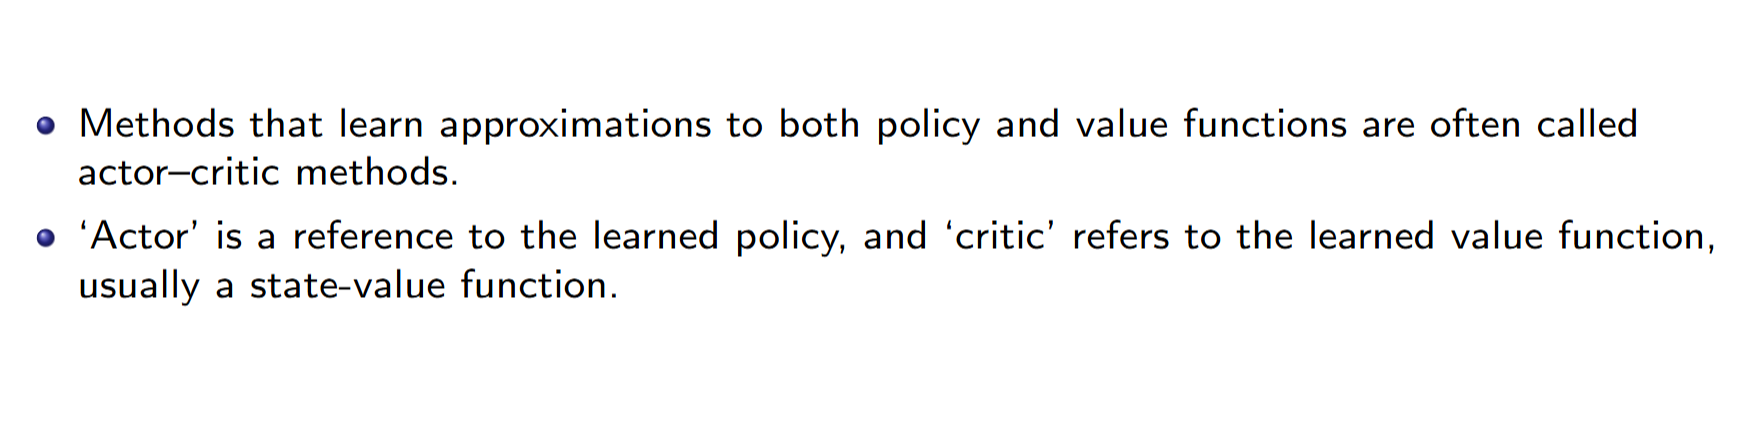

**VALUE FUNCTION REPRESENTATION**

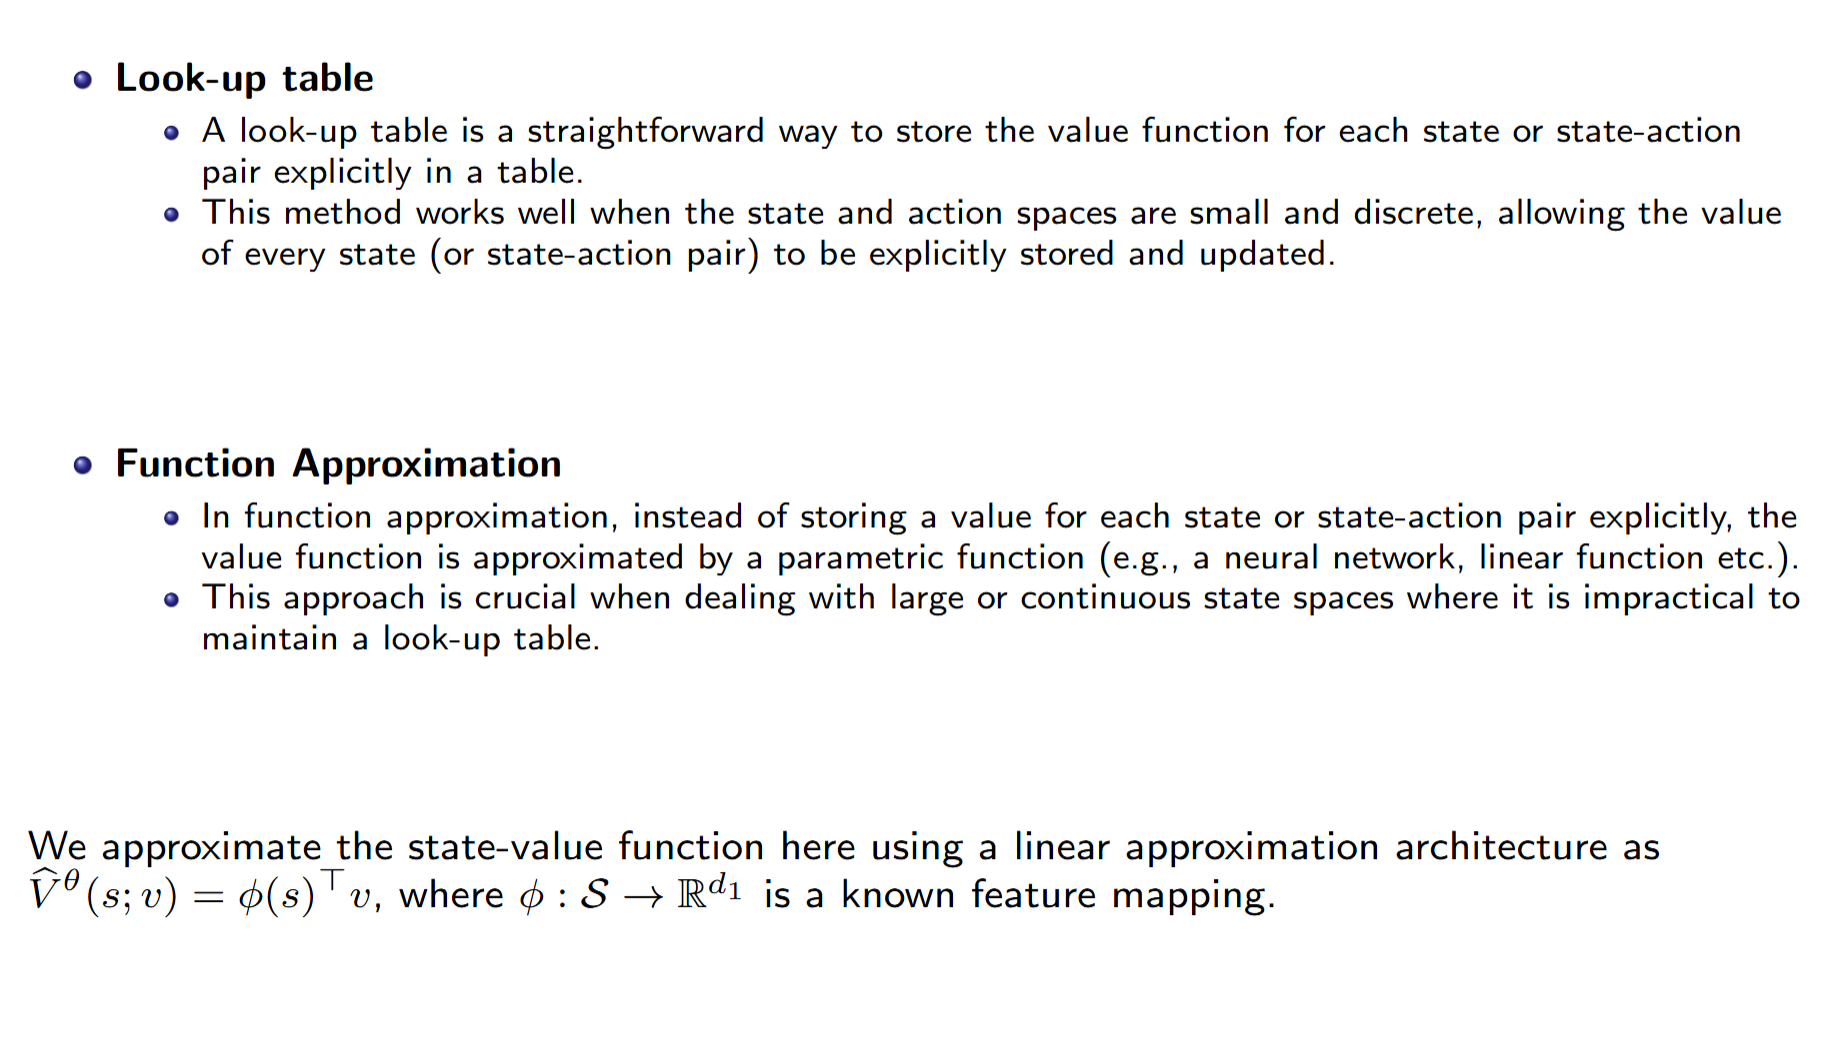

**ACTOR CRITIC ALGORITHM**

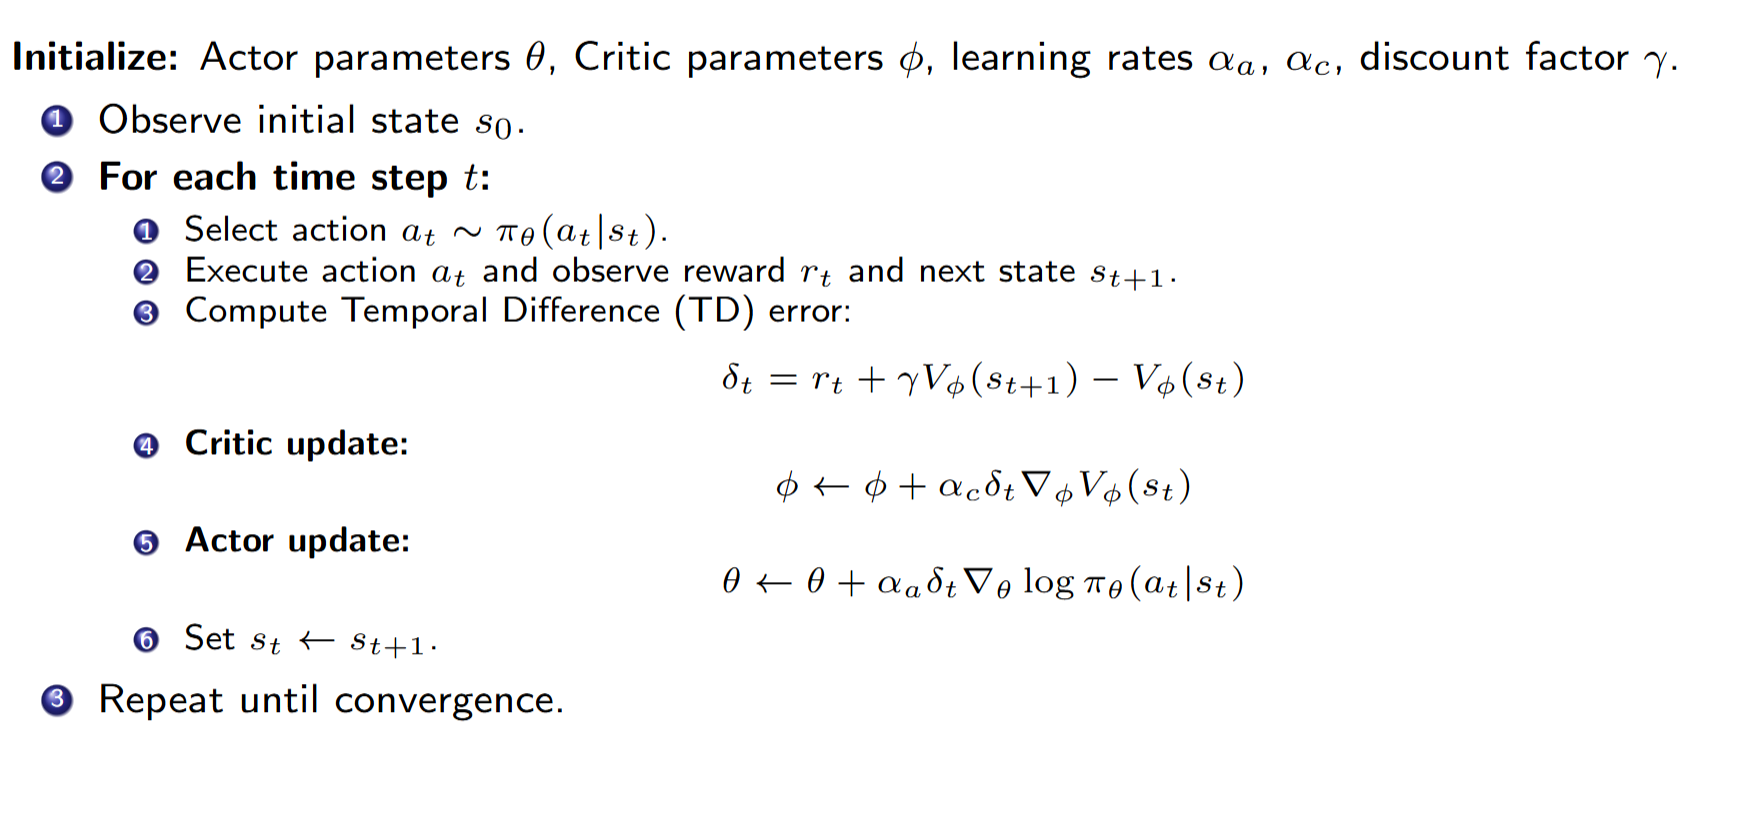

IMPLEMENTATION OF ACTOR CRITIC WITH POLICY GRADIENT

IMPORTS

In [ ]:
pip install torch gymnasium[classic-control]

In [ ]:
import numpy as np

# NumPy compatibility
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim


**FROZEN LAKE ENVIRONMENT**

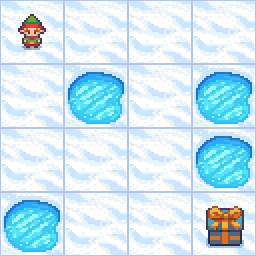

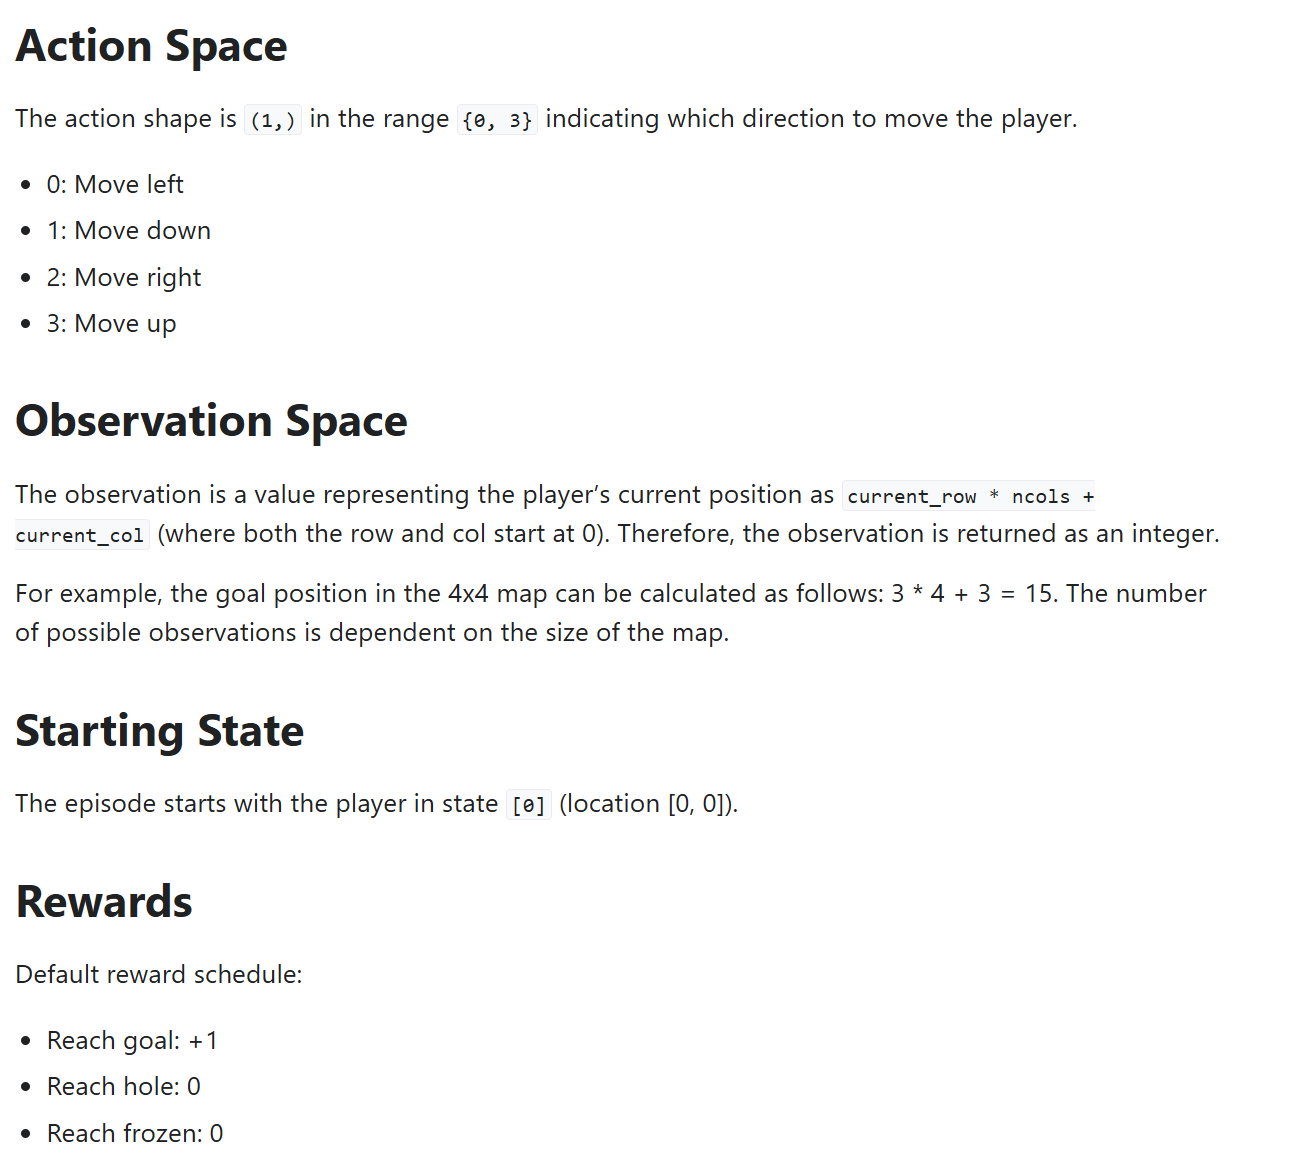

ACTOR CRITIC NETWORK

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )

        self.actor = nn.Sequential(
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Linear(128, 1)

    def forward(self, state):
        x = self.shared(state)
        return self.actor(x), self.critic(x)


TRAINING

In [ ]:
import matplotlib.pyplot as plt
def train_actor_critic(
    env_name="FrozenLake-v1",
    episodes=5000,
    gamma=0.99,
    lr=3e-4
):
    env = gym.make(env_name, is_slippery=False)

    # FrozenLake is Discrete
    state_dim = env.observation_space.n   # 16
    action_dim = env.action_space.n

    model = ActorCritic(state_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    episode_returns = []
    reward_sum = 0
    average_reward = []
    count = 0

    def one_hot(state):
        vec = torch.zeros(state_dim)
        vec[state] = 1.0
        return vec

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            state_tensor = one_hot(state)

            logits, value = model(state_tensor)
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            total_reward += reward

            with torch.no_grad():
                next_state_tensor = one_hot(next_state)
                _, next_value = model(next_state_tensor)

            td_error = reward + gamma * next_value * (1 - int(done)) - value

            actor_loss = -dist.log_prob(action) * td_error.detach()
            critic_loss = td_error.pow(2)

            loss = actor_loss + critic_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

            reward_sum += reward
            count += 1
            average_reward.append(reward_sum / count)

        episode_returns.append(total_reward)

        if episode % 500 == 0:
            print(f"Episode {episode}, Return: {total_reward}")

    env.close()

    plt.figure()
    plt.plot(average_reward)
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.title("Average Reward Over Time")
    plt.show()

    return episode_returns

RUN TRAINING

Episode 0, Return: 0
Episode 500, Return: 1
Episode 1000, Return: 0
Episode 1500, Return: 0
Episode 2000, Return: 1
Episode 2500, Return: 0
Episode 3000, Return: 1
Episode 3500, Return: 0
Episode 4000, Return: 0
Episode 4500, Return: 0


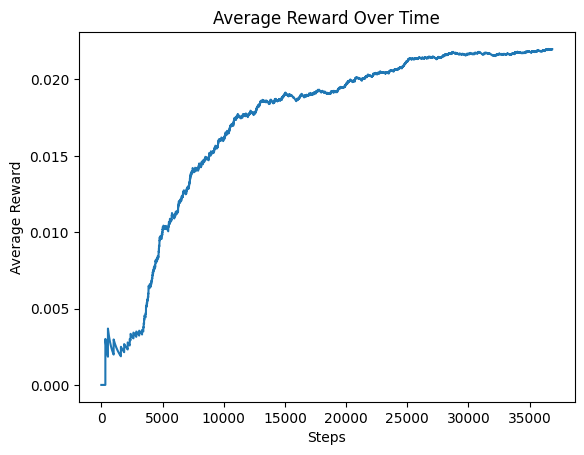

In [ ]:
returns = train_actor_critic()


**PENDULUM ENVIRONMENT**

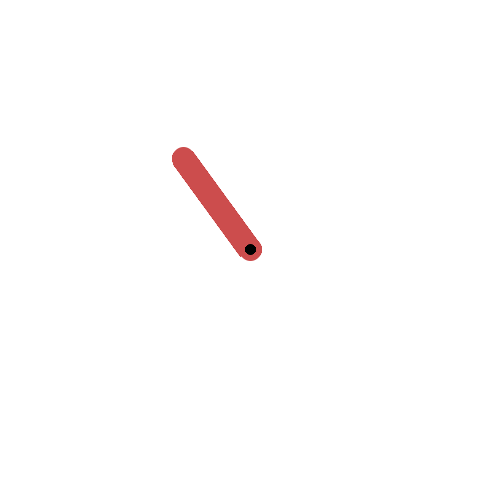

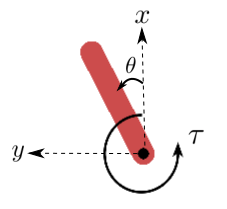

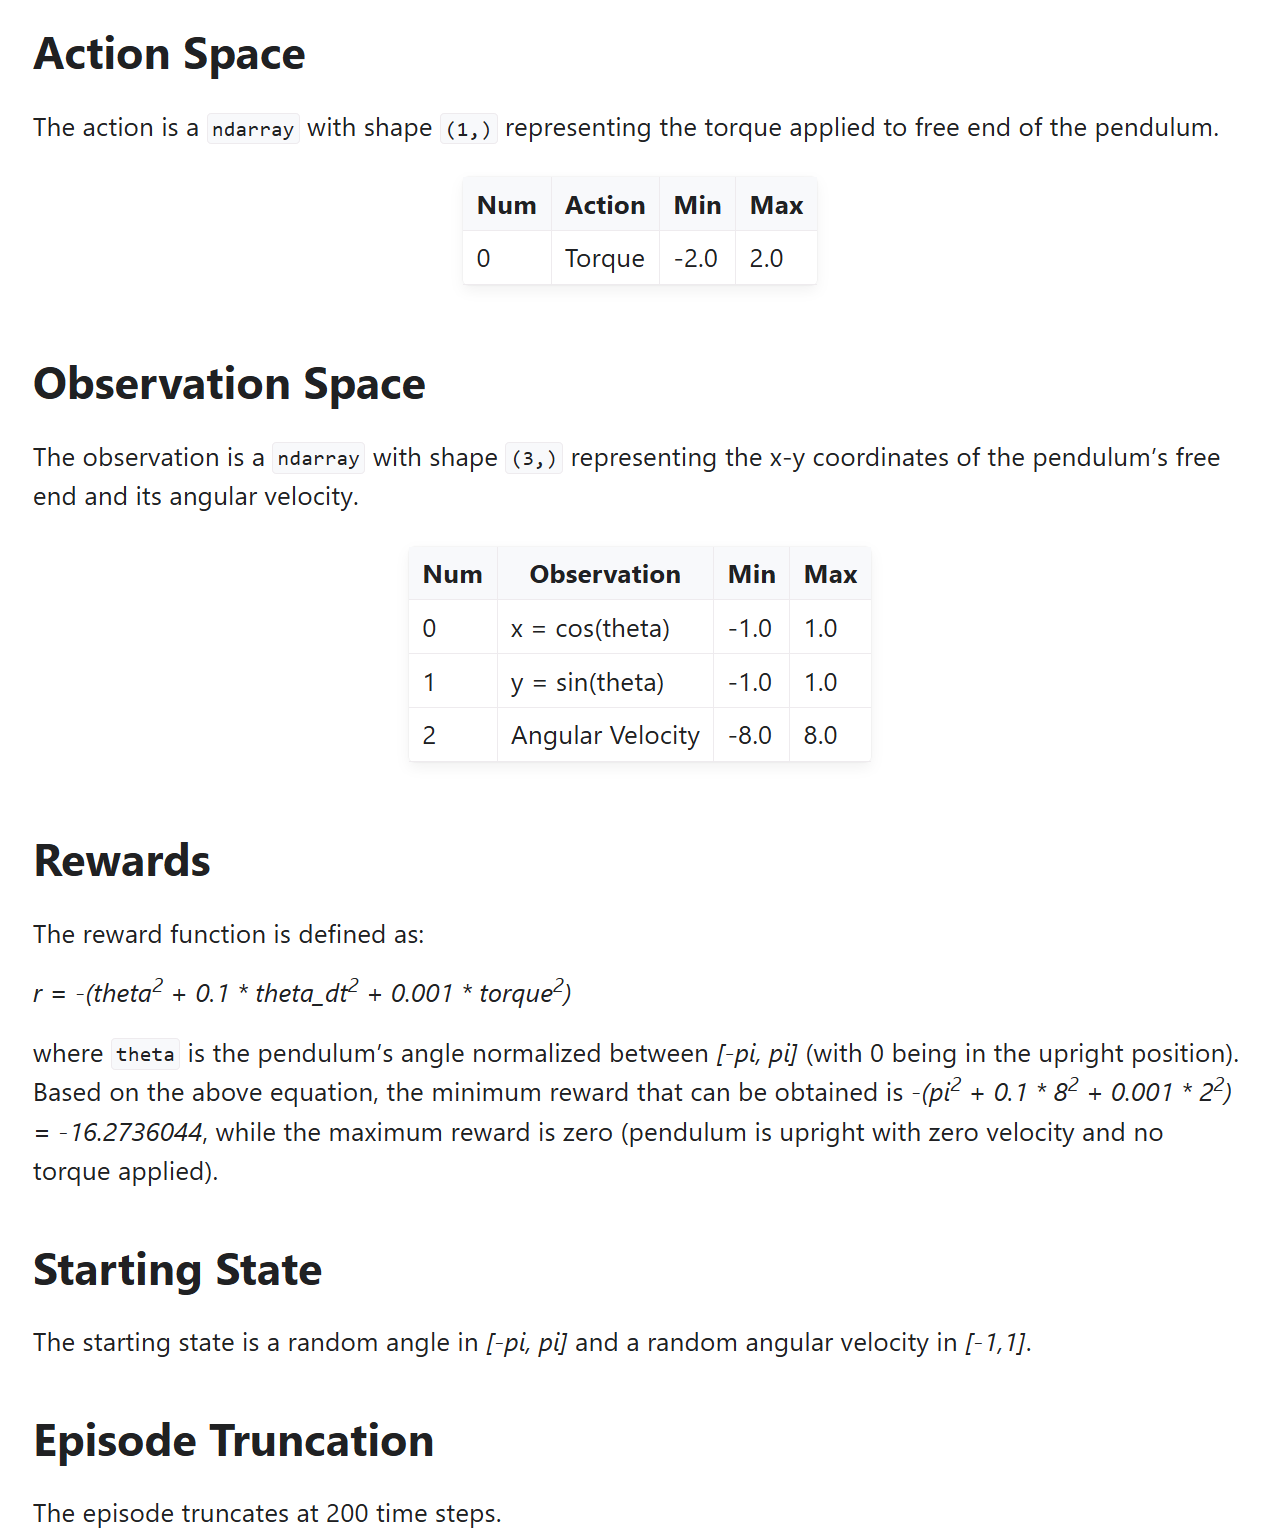

ACTOR CRITIC NETWORK

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )

        # Actor outputs mean of Gaussian
        self.actor_mean = nn.Linear(128, action_dim)
        self.actor_log_std = nn.Parameter(torch.zeros(action_dim))

        # Critic outputs value
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        mean = self.actor_mean(x)
        std = torch.exp(self.actor_log_std)
        value = self.critic(x)
        return mean, std, value



TRAINING

In [ ]:
def train_actor_critic_pendulum(
    env_name="Pendulum-v1",
    episodes= 300,
    gamma=0.99,
    lr=3e-4
):
    env = gym.make(env_name)

    state_dim = env.observation_space.shape[0]   # 3
    action_dim = env.action_space.shape[0]       # 1
    action_low = env.action_space.low[0]
    action_high = env.action_space.high[0]

    model = ActorCritic(state_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    episode_returns = []
    avg_rewards = []
    reward_sum = 0
    count = 0

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32)

            mean, std, value = model(state_tensor)
            dist = torch.distributions.Normal(mean, std)

            action = dist.sample()
            action_clipped = torch.clamp(action, action_low, action_high)

            next_state, reward, terminated, truncated, _ = env.step(
                action_clipped.detach().numpy()
            )
            done = terminated or truncated
            total_reward += reward

            with torch.no_grad():
                next_state_tensor = torch.tensor(next_state, dtype=torch.float32)
                _, _, next_value = model(next_state_tensor)

            td_error = reward + gamma * next_value * (1 - int(done)) - value

            actor_loss = -dist.log_prob(action).sum() * td_error.detach()
            critic_loss = td_error.pow(2)

            loss = actor_loss + critic_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

            reward_sum += reward
            count += 1
            avg_rewards.append(reward_sum / count)

        episode_returns.append(total_reward)

        if episode % 100 == 0:
            print(f"Episode {episode}, Return: {total_reward:.2f}")

    env.close()

    plt.figure()
    plt.plot(avg_rewards)
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.title("Average Reward Over Time (Pendulum)")
    plt.show()

    return

RUN TRAINING

Episode 0, Return: -1706.44
Episode 100, Return: -1431.11
Episode 200, Return: -1443.97


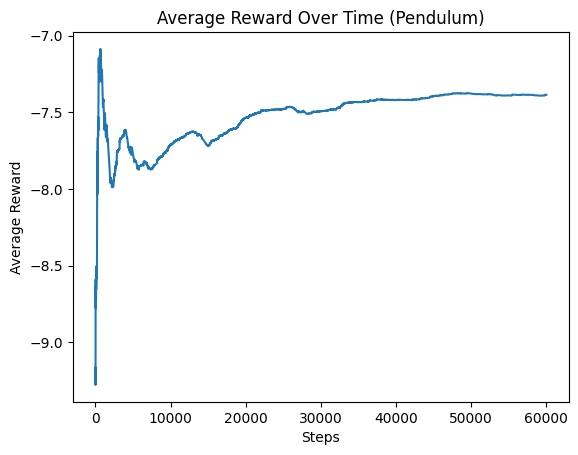

In [ ]:
train_actor_critic_pendulum()

**MOUNTAIN CAR CONTINOUS**

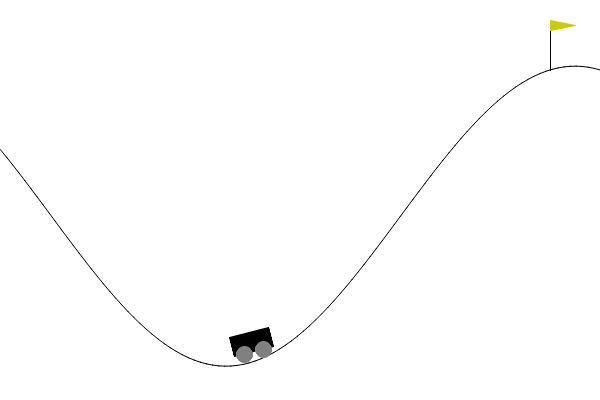

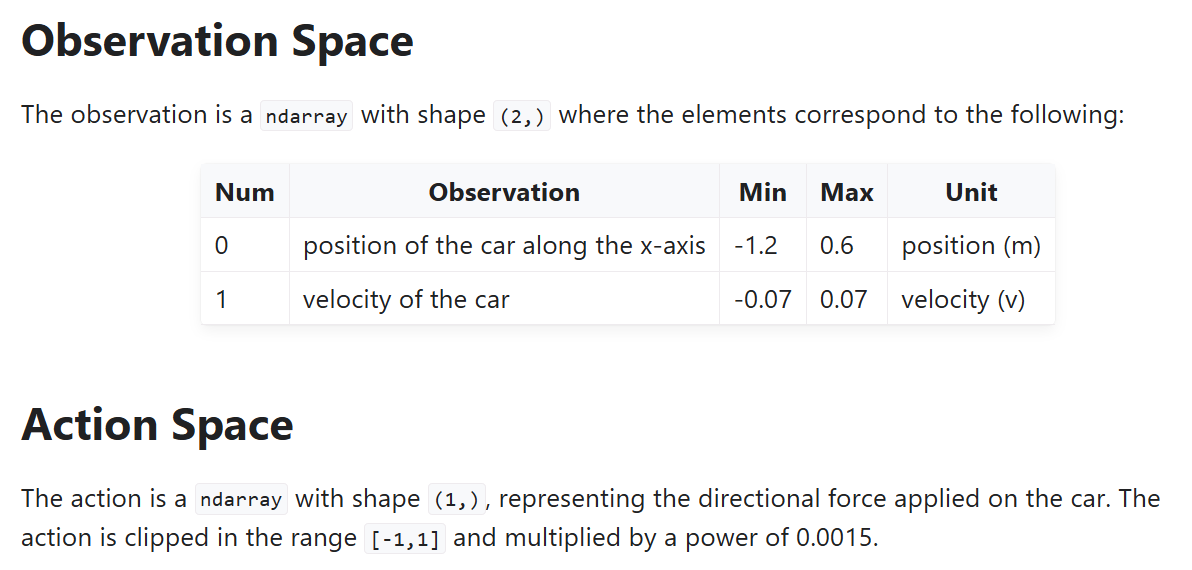

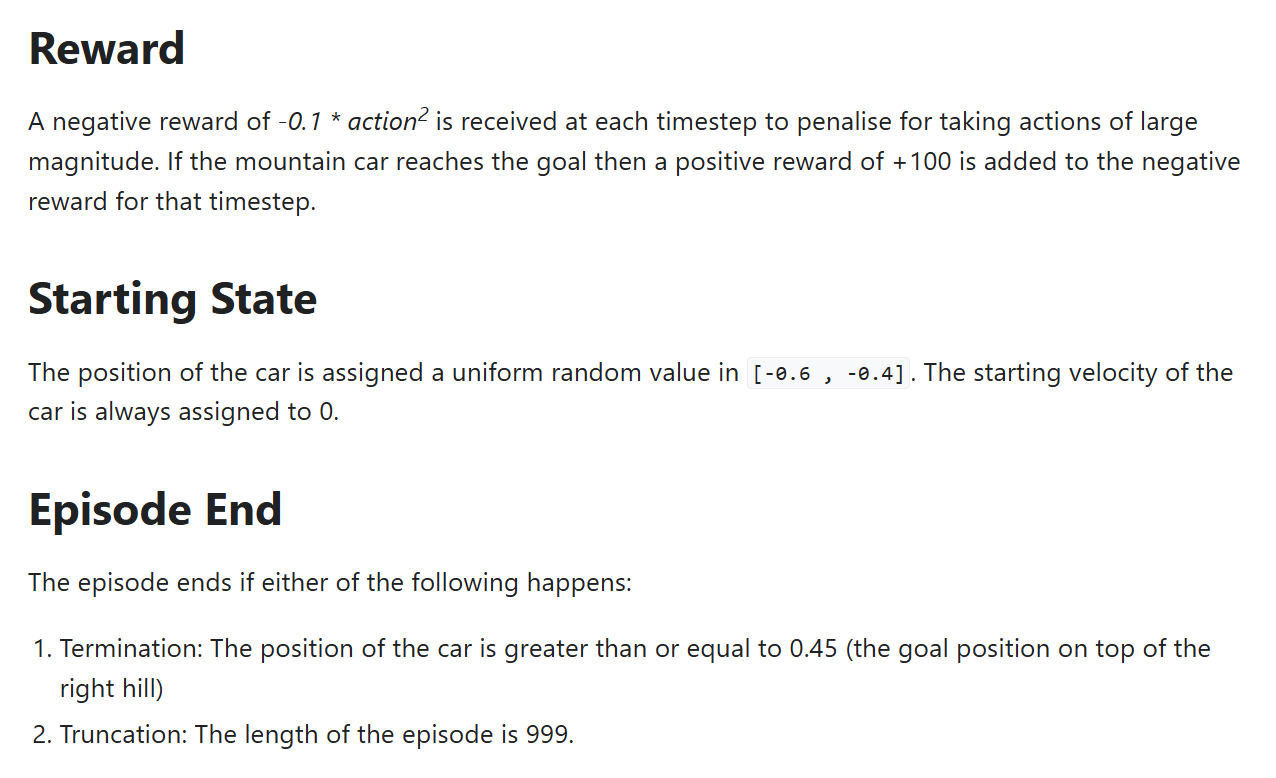

ACTOR CRITIC FRAMEWORK

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )
        # Actor outputs mean of Gaussian
        self.actor_mean = nn.Linear(128, action_dim)
        # Learnable log std
        self.actor_log_std = nn.Parameter(torch.zeros(action_dim))
        # Critic outputs value
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        mean = self.actor_mean(x)
        std = torch.exp(self.actor_log_std)
        value = self.critic(x)
        return mean, std, value


TRAINING

In [ ]:
def train_actor_critic_mountain_car(env_name="MountainCarContinuous-v0",
                       episodes=100,
                       gamma=0.99,
                       lr=3e-4):

    env = gym.make(env_name)

    state_dim = env.observation_space.shape[0]  # 2
    action_dim = env.action_space.shape[0]      # 1
    action_low = env.action_space.low[0]        # -1
    action_high = env.action_space.high[0]      # 1

    model = ActorCritic(state_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    episode_returns = []
    avg_rewards = []
    reward_sum = 0
    count = 0

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32)

            # Actor-Critic forward pass
            mean, std, value = model(state_tensor)
            dist = torch.distributions.Normal(mean, std)
            action = dist.sample()
            action_clipped = torch.clamp(action, action_low, action_high)

            # Step environment
            next_state, reward, terminated, truncated, _ = env.step(
                action_clipped.detach().numpy()
            )
            done = terminated or truncated
            total_reward += reward

            # TD target
            with torch.no_grad():
                next_state_tensor = torch.tensor(next_state, dtype=torch.float32)
                _, _, next_value = model(next_state_tensor)

            td_error = reward + gamma * next_value * (1 - int(done)) - value

            actor_loss = -dist.log_prob(action).sum() * td_error.detach()
            critic_loss = td_error.pow(2)
            loss = actor_loss + critic_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            reward_sum += reward
            count += 1
            avg_rewards.append(reward_sum / count)

        episode_returns.append(total_reward)

        if episode % 100 == 0:
            print(f"Episode {episode}, Return: {total_reward:.2f}")

    env.close()

    plt.figure()
    plt.plot(avg_rewards)
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.title("Average Reward Over Time (MountainCarContinuous)")
    plt.show()

    return


RUN TRAINING

Episode 0, Return: -47.33
Episode 10, Return: -13.02
Episode 20, Return: -4.28
Episode 30, Return: -1.57
Episode 40, Return: -0.57
Episode 50, Return: -0.18
Episode 60, Return: -0.08
Episode 70, Return: -0.03
Episode 80, Return: -0.09
Episode 90, Return: -0.01


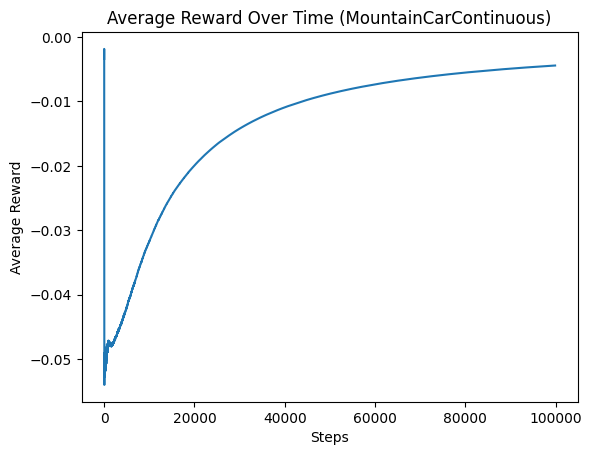

In [ ]:
train_actor_critic_mountain_car()

**RESEARCH WORK**

https://drive.google.com/file/d/13kzb1uLWc_hvPmmkjNdjF6frOBD-fUXi/view?usp=drive_link